# Улучшение процесса обогащения золота


Заказчиком является инжиниринговая компания, которая разрабатывает решения для эффективной работы промышленных предприятий.

Требуется подготовить прототип модели машинного обучения, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками

## Данные

В нашем распоряжении имеются данные с параметрами добычи и очистки.

*Данные находятся в трёх файлах:*
- gold_recovery_train.csv — обучающая выборка;
- gold_recovery_test.csv — тестовая выборка;
- gold_recovery_full.csv — исходные данные.

Данные индексируются датой и временем получения информации (признак date).
Соседние по времени параметры часто похожи. Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

Данные в нашем распоряжении являются сырыми: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, требуется проверить их на корректность согласно согласованной с заказчиком инструкции.

**Наименование признаков**

Наименование признаков строится по следующему правилу:

[этап].[тип_параметра].[название_параметра]


Пример: rougher.input.feed_ag

*Возможные значения для блока* [этап]:

- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики


Возможные значения для блока [тип_параметра]:

- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

**План работы**

Подготовка данных

1. Открыть и изучить файлы.
2. Провести предобработку данных. Убрать или заменить пропуски, привести данные к нужным типам.
3. Проверить, что эффективность обогащения рассчитана правильно. Вычислить её на обучающей выборке для признака rougher.output.recovery. Найти MAE между расчитанным и имеющимся значением признака. Описать выводы.
4. Проанализировать признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

Проанализировать данные

1. Изучить, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Описать выводы.
2. Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.
3. Исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Проверить, есть ли аномальные значения в суммарном распределении. Определить, если они есть, следует ли их удалять из обеих выборок? Описать выводы и удалить аномалии в соответствии с принятыми правилами, если найдутся.

Построить модель

1. Написать функцию для вычисления итоговой sMAPE.
2. Обучить разные модели и оценить их качество кросс-валидацией.
3. Выбрать лучшую модель и проверить её на тестовой выборке.
4. Описать выводы.


## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score)
from sklearn.linear_model import (LinearRegression, LogisticRegression)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import (
    mean_absolute_error as mae,
    accuracy_score,
    make_scorer
)
import warnings

In [ ]:
train_df = pd.read_csv('/datasets/gold_industry_train.csv')
test_df = pd.read_csv('/datasets/gold_industry_test.csv')
full_df = pd.read_csv('/datasets/gold_industry_full.csv')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


In [ ]:
train_df.describe(include = 'all')

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,14579,14579.000000,14579.000000,14507.000000,14502.000000,14572.000000,14478.000000,14548.000000,14572.000000,14579.000000,...,13659.000000,14579.000000,14578.000000,14578.000000,14387.000000,14579.000000,14579.000000,14578.000000,14504.000000,14574.000000
unique,14579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2017-09-13 06:59:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,8.352941,8.877460,3.604221,36.561420,474.332784,58.922712,12.427399,5.994854,1104.208278,...,7.111347,43.979499,5.192145,9.923809,9.566676,66.759066,3.087939,9.731972,2.719985,10.612745
std,NaN,1.934376,1.922536,1.056063,5.209823,108.503552,22.407410,3.428939,1.152873,162.235606,...,3.909951,5.471437,1.388014,1.706976,2.805654,10.619709,0.915187,2.358143,0.958929,2.871075
min,NaN,0.010000,0.010000,0.010000,0.010000,0.002986,0.049194,0.001083,0.000568,-0.042069,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,6.932996,7.341922,2.880490,34.093951,411.048483,47.278490,10.002832,5.304167,999.644856,...,3.784897,43.345906,4.283347,9.103183,7.860030,63.114596,2.505287,8.088928,2.036512,9.013412
50%,NaN,8.225284,8.715859,3.532399,37.097511,498.187968,54.361187,12.003320,6.003053,1000.982624,...,7.629968,44.975014,5.118647,10.046455,9.301970,67.962788,3.029238,9.818512,2.774847,10.670515
75%,NaN,9.832210,10.255843,4.257282,39.899799,549.586552,64.464926,14.929903,6.796632,1292.663971,...,10.367050,46.275153,5.925380,10.981203,11.001573,72.598187,3.614098,11.169187,3.353845,12.130827


In [ ]:
train_df.isna().sum()

date                       0
rougher.input.feed_au      0
rougher.input.feed_ag      0
rougher.input.feed_pb     72
rougher.input.feed_sol    77
                          ..
final.output.recovery      0
final.output.tail_au       0
final.output.tail_ag       1
final.output.tail_pb      75
final.output.tail_sol      5
Length: 87, dtype: int64

In [ ]:
train_df.head()

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

In [ ]:
test_df.isna().sum()

date                                            0
rougher.input.feed_au                           0
rougher.input.feed_ag                           0
rougher.input.feed_pb                          28
rougher.input.feed_sol                         22
rougher.input.feed_rate                         4
rougher.input.feed_size                        44
rougher.input.floatbank10_sulfate               3
rougher.input.floatbank10_xanthate              1
rougher.state.floatbank10_a_air                 1
rougher.state.floatbank10_a_level               1
rougher.state.floatbank10_b_air                 1
rougher.state.floatbank10_b_level               1
rougher.state.floatbank10_c_air                 1
rougher.state.floatbank10_c_level               1
rougher.state.floatbank10_d_air                 0
rougher.state.floatbank10_d_level               0
rougher.state.floatbank10_e_air                 7
rougher.state.floatbank10_e_level               0
rougher.state.floatbank10_f_air                 0


In [ ]:
test_df.head()

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805


In [ ]:
full_df.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,19439.000000,19439.000000,19339.000000,19340.000000,19428.000000,19294.000000,19405.000000,19431.000000,19438.000000,19438.000000,...,17691.000000,19439.000000,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000
mean,8.266097,8.794927,3.598085,36.695114,478.320042,58.970310,12.334373,6.021474,1105.315068,-376.610690,...,7.167247,44.076513,5.168470,9.978895,9.501224,67.050208,3.042467,9.688589,2.705795,10.583728
std,1.955092,1.936847,1.049486,5.145445,105.373758,21.634478,3.427317,1.127263,160.826798,93.909667,...,3.916079,5.129784,1.372348,1.669240,2.787537,10.125840,0.922808,2.328642,0.949077,2.868782
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.046369,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.854384,7.237967,2.887280,34.207799,416.525453,47.435103,10.000362,5.398678,999.661867,-499.835165,...,3.845475,43.402215,4.251240,9.137262,7.722820,63.299712,2.461138,8.062878,2.040119,8.938947
50%,8.125839,8.593574,3.534895,37.202650,499.416120,54.610197,12.001174,6.008273,1001.072890,-300.263994,...,7.685827,45.011244,5.066094,10.102433,9.218961,68.172738,2.984909,9.743623,2.748730,10.622456
75%,9.769917,10.213771,4.244161,40.039133,550.172183,65.023044,14.716595,6.798051,1205.620588,-299.981998,...,10.411296,46.275313,5.895527,11.035769,10.947813,72.686642,3.571351,11.134294,3.333216,12.104271
max,13.731330,14.596026,7.142594,53.477742,717.508837,484.967466,36.118275,9.703448,1521.980372,-273.776101,...,26.000772,52.756638,16.001945,17.031899,19.615720,100.000000,8.245022,19.552149,5.804178,22.317730


In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


In [ ]:
full_df.columns.isin(train_df.columns).sum()

87

**Вывод:** Данные представлены в 3х датафреймах, в тренировочном и полном по 87 колонок, в тестовом 52. Есть пропуски в данных.

### Предобработка

#### Индексирование данных датой

Для удобства дальшейшего использования и сортировки удобнее всего вывести дату в индексы и удалить столбец с датой

In [ ]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df.index = train_df['date']
train_df = train_df.drop(['date'], axis =1)
train_df.sort_index()
train_df.head(2)

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514


In [ ]:
test_df['date'] = pd.to_datetime(test_df['date'])
test_df.index = test_df['date']
test_df = test_df.drop(['date'], axis =1)
train_df.sort_index()
test_df.head(2)

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,-299.862743,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,-299.907308,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


In [ ]:
full_df['date'] = pd.to_datetime(full_df['date'])
full_df.index = full_df['date']
full_df = full_df.drop(['date'], axis =1)
train_df.sort_index()
full_df.head(2)

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514


#### Анализ признаков, недоступных в тестовой выборке

In [ ]:
warnings.filterwarnings("ignore")
hidden_columns = list(train_df.columns ^ test_df.columns)
hidden_columns

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

**Вывод:** Проанализировав признаки, недоступные в тестовой выборке можно сделать вывод, что это параметры, которые замеряются и/или рассчитываются значительно позже и результаты обработки металлов.

#### Заполнение пропусков в данных

Данные индексируются датой и временем получения информации. По информации от заказчика близкие по времени данные имеют похожие значения.Поэтому я приняла решение по заполнению пропусков в тренировочных данных ближайшими значениями, строки с пропусками в целевых значениях следует исключить.

In [ ]:
train_df[['rougher.output.recovery', 'final.output.recovery']].isna().sum()

rougher.output.recovery    0
final.output.recovery      0
dtype: int64

In [ ]:
train_df = train_df.fillna(method='ffill')
train_df.isna().sum()

rougher.input.feed_au      0
rougher.input.feed_ag      0
rougher.input.feed_pb      0
rougher.input.feed_sol     0
rougher.input.feed_rate    0
                          ..
final.output.recovery      0
final.output.tail_au       0
final.output.tail_ag       0
final.output.tail_pb       0
final.output.tail_sol      0
Length: 86, dtype: int64

In [ ]:
train_df.shape

(14579, 86)

**Вывод:** В данных отсутствовали пропуски в целевых столбцах. поэтому было выполнено только заполнение ячеек с признаками в тренировочном датасете.

#### Проверка эффективности обогащения

Для оценки качества предоставленных данных необходимо проверить, что эффективность обогащения рассчитана правильно. Необходимо вычислить её на обучающей выборке для признака rougher.output.recovery. Определить качество можно с помощью вычисления средней абсолютной ошибки - MAE между расчётами и значением признака.

rougher.output.recovery (эффективность обогащения на флотации) можно расчитать по формуле

Recovery = (C x (F-T))/(F x (C-T)) x 100%

где:

- C = доля золота (au) в концентрате (concentrate) после (output) флотации (rougher) - rougher.output.concentrate_au
- F = доля золота в сырье (feed_au) до (input) флотации (rougher) - rougher.input.feed_au
- T = доля золота в отвальных хвостах (tail_au) после (output) флотации (rougher) - rougher.output.tail_au

In [ ]:
C = train_df['rougher.output.concentrate_au']
F = train_df['rougher.input.feed_au']
T = train_df['rougher.output.tail_au']

In [ ]:
train_df['rougher.output.recovery_calc'] = (C * (F-T))/(F * (C-T)) * 100
train_df['rougher.output.recovery_calc'].mean()

82.52119968211336

In [ ]:
train_df['rougher.output.recovery'].mean()

82.52119968211336

In [ ]:
mae(
    train_df['rougher.output.recovery'],
    train_df['rougher.output.recovery_calc']
)

9.83758577644259e-15

In [ ]:
train_df = train_df.drop(['rougher.output.recovery_calc'], axis=1)

**Вывод:** По итогам анализа средняя абсолютная ошибка (MAE) показала результат близкий к 0, что говорит о том, что в данных эффективность обагащения расчитана правильно.

## Анализ данных

**Процесс производства:**

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.
1. Флотация
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
2. Очистка
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

### Анализ того, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

#### Анализ концентрации Золота(Au) на разных этапах очистки

In [ ]:
print('Среднее значение концентрации золота на этапах очистки:')
print(train_df['rougher.input.feed_au'].mean())
print(train_df['rougher.output.concentrate_au'].mean())
print(train_df['primary_cleaner.output.concentrate_au'].mean())
print(train_df['final.output.concentrate_au'].mean())

Среднее значение концентрации золота на этапах очистки:
8.352940920963524
19.71747030146708
32.00753497230735
43.97949926726813


In [ ]:
def concentrate_plot (stage_1, stage_2, stage_3, stage_4, name):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot()

    ax.hist(stage_1, edgecolor='None', alpha = 0.5, color= 'yellow', label="Сырье")
    ax.hist(stage_2, edgecolor="None", alpha = 0.5, color= 'green', label="Черновой концентрат")
    ax.hist(stage_3, edgecolor='None', alpha = 0.5, color= 'red', label="Первая очистка")
    ax.hist(stage_4, edgecolor='None', alpha = 0.5, color= 'blue', label="Финальный концентрат")

    plt.xlabel('concentrate', fontsize=12)
    plt.ylabel('number', fontsize=12)
    plt.title(name, fontsize=16)
    plt.legend(fontsize=14)

    plt.show()

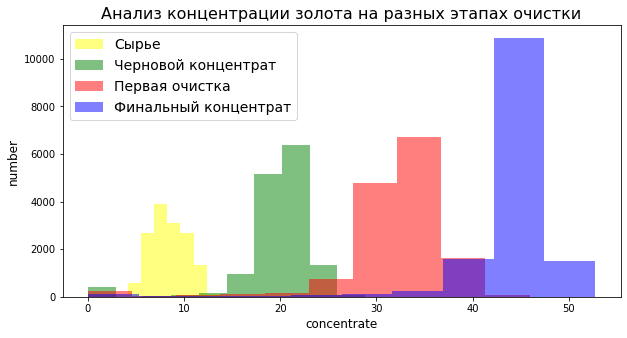

In [ ]:
concentrate_plot(
    train_df['rougher.input.feed_au'],
    train_df['rougher.output.concentrate_au'],
    train_df['primary_cleaner.output.concentrate_au'],
    train_df['final.output.concentrate_au'],
    'Анализ концентрации золота на разных этапах очистки'
)

In [ ]:
print(train_df['rougher.input.feed_au'].min())
print(train_df['rougher.output.concentrate_au'].min())
print(train_df['primary_cleaner.output.concentrate_au'].min())
print(train_df['final.output.concentrate_au'].min())

0.0099999997764825
0.0
0.0
0.0


In [ ]:
train_df = train_df.loc[(
    train_df['rougher.output.concentrate_au'] > 0)& (
    train_df['primary_cleaner.output.concentrate_au'] > 0) & (
    train_df['final.output.concentrate_au'] > 0)
]

In [ ]:
print(train_df['rougher.input.feed_au'].min())
print(train_df['rougher.output.concentrate_au'].min())
print(train_df['primary_cleaner.output.concentrate_au'].min())
print(train_df['final.output.concentrate_au'].min())

0.0099999997764825
0.0099999997764825
0.0099999997764825
0.0099999997764825


In [ ]:
print('Среднее значение концентрации золота на этапах очистки:')
print(train_df['rougher.input.feed_au'].mean())
print(train_df['rougher.output.concentrate_au'].mean())
print(train_df['primary_cleaner.output.concentrate_au'].mean())
print(train_df['final.output.concentrate_au'].mean())

Среднее значение концентрации золота на этапах очистки:
8.344555412800952
20.26810308658852
32.20998029325248
44.26677857582459


**Вывод:** Результаты анализа концентрации золота на разных этапах очистки показывают, что концентрация растет от этапа к этапу очистки и достигает максимальных значений на финальных замерах. Данные распределены нормально. Средние показатели концентрации меняются в среднем от 8.34 в исходном сырье до 44.27 на финальном.

#### Анализ концентрации Серебра(Ag) на разных этапах очистки

In [ ]:
print(train_df['rougher.input.feed_ag'].mean())
print(train_df['rougher.output.concentrate_ag'].mean())
print(train_df['primary_cleaner.output.concentrate_ag'].mean())
print(train_df['final.output.concentrate_ag'].mean())

8.872197749602394
12.282856207478627
8.553669833075409
5.234226036980026


In [ ]:
print('Среднее значение концентрации золота на этапах очистки:')
print(train_df['rougher.input.feed_au'].min())
print(train_df['rougher.output.concentrate_au'].min())
print(train_df['primary_cleaner.output.concentrate_au'].min())
print(train_df['final.output.concentrate_au'].min())

Среднее значение концентрации золота на этапах очистки:
0.0099999997764825
0.0099999997764825
0.0099999997764825
0.0099999997764825


<function matplotlib.pyplot.show(close=None, block=None)>

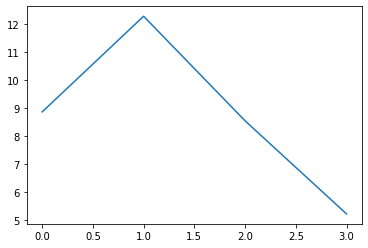

In [ ]:
ag_mean = []
ag_mean.append(train_df['rougher.input.feed_ag'].mean())
ag_mean.append(train_df['rougher.output.concentrate_ag'].mean())
ag_mean.append(train_df['primary_cleaner.output.concentrate_ag'].mean())
ag_mean.append(train_df['final.output.concentrate_ag'].mean())
plt.plot(ag_mean)
plt.show

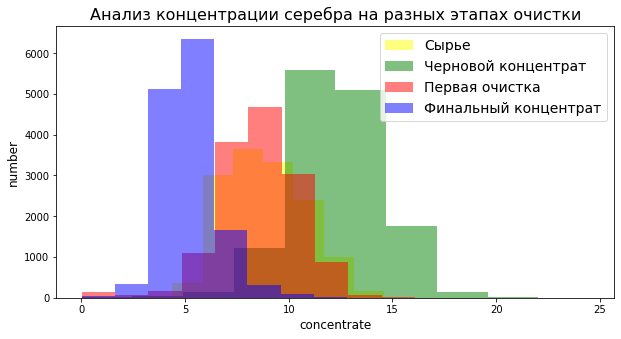

In [ ]:
concentrate_plot(
    train_df['rougher.input.feed_ag'],
    train_df['rougher.output.concentrate_ag'],
    train_df['primary_cleaner.output.concentrate_ag'],
    train_df['final.output.concentrate_ag'],
    'Анализ концентрации серебра на разных этапах очистки'
)

**Вывод:** Результаты анализа концентрации серебра на разных этапах очистки показывают, что концентрация металла существенно уменьшается на финальном этапе.


Необходимо обратить внимание заказчика на имеющиеся проблемы с данными по серебру, скорее всего в них закралась ошибка

#### Анализ концентрации Свинца(Pb) на разных этапах очистки

In [ ]:
print(train_df['rougher.input.feed_pb'].mean())
print(train_df['rougher.output.concentrate_pb'].mean())
print(train_df['primary_cleaner.output.concentrate_pb'].mean())
print(train_df['final.output.concentrate_pb'].mean())

3.5853280231669955
7.699265886688221
9.7931997007007
9.990775499812074


In [ ]:
print(train_df['rougher.input.feed_pb'].min())
print(train_df['rougher.output.concentrate_pb'].min())
print(train_df['primary_cleaner.output.concentrate_pb'].min())
print(train_df['final.output.concentrate_pb'].min())

0.0099999997764825
0.0099999997764825
0.0
0.0099999997764825


In [ ]:
train_df = train_df.loc[train_df['primary_cleaner.output.concentrate_pb'] > 0]
print(train_df['primary_cleaner.output.concentrate_pb'].min())

0.0099999997764825


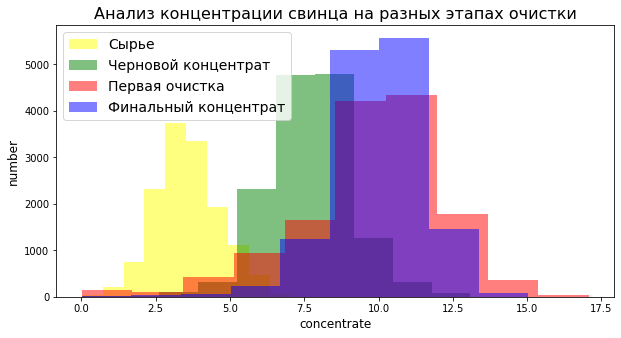

In [ ]:
concentrate_plot(
    train_df['rougher.input.feed_pb'],
    train_df['rougher.output.concentrate_pb'],
    train_df['primary_cleaner.output.concentrate_pb'],
    train_df['final.output.concentrate_pb'],
    'Анализ концентрации свинца на разных этапах очистки'
)

**Вывод:** Результаты анализа концентрации свинца на разных этапах очистки показывают, что концентрация растет от этапа к этапу очистки и достигает максимальных значений на финальных замерах. Разница между средними на последних этапах не существенна. Данные распределены нормально. Средние показатели концентрации меняются в среднем от 3.64 в исходном сырье до 9.96 на финальном.

### Сравнение распределения размеров гранул исходного сырья на обучающей и тестовой выборках.

Необходимо провести сравнение распределения размеров гранул исходного сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

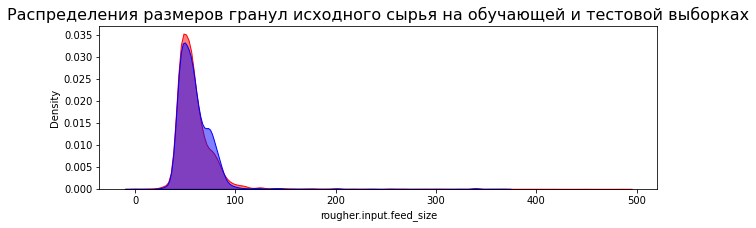

In [ ]:
plt.rcParams["figure.figsize"] = [10, 3]
sns.kdeplot(train_df['rougher.input.feed_size'], fill=True, alpha = 0.5, color= 'red', label="Тренировочная выборка")
sns.kdeplot(test_df['rougher.input.feed_size'], fill=True, alpha = 0.5, color= 'blue', label="Тестовая выборка")
plt.title('Распределения размеров гранул исходного сырья на обучающей и тестовой выборках', fontsize=16)

plt.show()

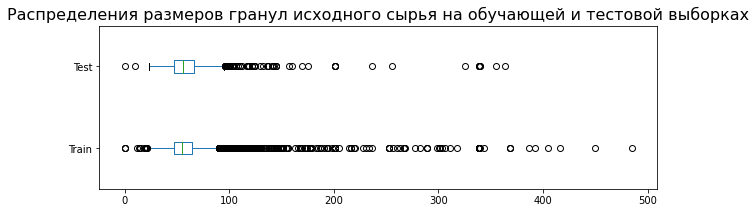

In [ ]:
plt.rcParams["figure.figsize"] = [10, 3]

data_boxplot = pd.DataFrame({"Train": train_df['rougher.input.feed_size'], "Test": test_df['rougher.input.feed_size']})
ax = data_boxplot[['Train', 'Test']].plot(kind='box', title='boxplot', vert=False)
plt.title('Распределения размеров гранул исходного сырья на обучающей и тестовой выборках', fontsize=16)

plt.show()

**Вывод:** По итогам сравнение распределения размеров гранул исходного сырья на обучающей и тестовой выборках можно сделать вывод, они не отличаются друг от друга и не повлияют на оценку модели.

### Исследование суммарной концентрации металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

Для удобства анализа удобно объединить данные об итогах каждого этапа в отдельной таблице

In [ ]:
df_sum = pd.DataFrame(index = train_df.index)

df_sum['rougher.input.feed_sum'] = (
    train_df['rougher.input.feed_au'] + train_df['rougher.input.feed_au'] + train_df['rougher.input.feed_au']
)

df_sum['rougher.output.concentrate_sum'] = (
    train_df['rougher.output.concentrate_au'] + train_df['rougher.output.concentrate_ag'] + train_df['rougher.output.concentrate_pb']
)

df_sum['primary_cleaner.output.concentrate_sum'] = (
    train_df['primary_cleaner.output.concentrate_au'] + train_df['primary_cleaner.output.concentrate_ag'] + train_df['primary_cleaner.output.concentrate_pb']
)


df_sum['final.output.concentrate_sum'] = (
    train_df['final.output.concentrate_au'] + train_df['final.output.concentrate_ag'] + train_df['final.output.concentrate_pb']
)

df_sum.head()

,rougher.input.feed_sum,rougher.output.concentrate_sum,primary_cleaner.output.concentrate_sum,final.output.concentrate_sum
date,,,,
2016-01-15 00:00:00,19.458449,38.395653,53.111627,58.137072
2016-01-15 01:00:00,19.435748,38.945647,53.174338,58.699942
2016-01-15 02:00:00,19.086666,38.649756,52.927464,58.927421
2016-01-15 03:00:00,18.354568,38.411473,43.979185,58.714815
2016-01-15 04:00:00,16.991120,38.867359,52.121146,59.065251


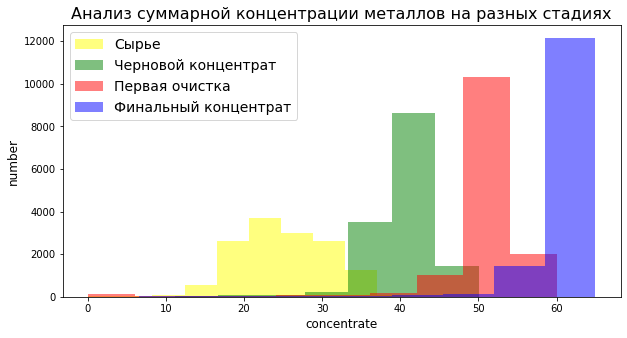

In [ ]:
concentrate_plot(
    df_sum['rougher.input.feed_sum'],
    df_sum['rougher.output.concentrate_sum'],
    df_sum['primary_cleaner.output.concentrate_sum'],
    df_sum['final.output.concentrate_sum'],
    'Анализ суммарной концентрации металлов на разных стадиях'
)

**Вывод:** Результаты анализа концентрации всех металлов на разных этапах очистки показывают, что концентрация растет от этапа к этапу очистки и достигает максимальных значений на финальных замерах. Данные распределены нормально.

In [ ]:
print(df_sum['rougher.input.feed_sum'].min())
print(df_sum['rougher.output.concentrate_sum'].min())
print(df_sum['primary_cleaner.output.concentrate_sum'].min())
print(df_sum['final.output.concentrate_sum'].min())

0.029999999329447503
0.029999999329447503
0.029999999329447503
0.029999999329447503


## Модель

Для решения задачи нужно спрогнозировать две величины:
эффективность обогащения чернового концентрата rougher.output.recovery;
эффективность обогащения финального концентрата final.output.recovery.
Итоговая метрика складывается из двух величин

#### Разделение тренировочных данных на признаки и целевые

In [ ]:
train_df_features = train_df.drop(hidden_columns, axis=1)
train_df_features.shape

(13982, 52)

In [ ]:
train_df_target = train_df[['rougher.output.recovery', 'final.output.recovery']]

In [ ]:
train_df_target.shape

(13982, 2)

In [ ]:
train_df_target.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13982 entries, 2016-01-15 00:00:00 to 2017-12-09 13:59:59
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rougher.output.recovery  13982 non-null  float64
 1   final.output.recovery    13982 non-null  float64
dtypes: float64(2)
memory usage: 843.7 KB


In [ ]:
train_df_target1 = np.array(train_df_target)

### Функция для вычисления итоговой sMAPE.

In [ ]:
def smape(target, predictions):
    numerator = np.abs(predictions-target)
    denominator = (np.abs(target) + np.abs(predictions))/2
    return 1/len(target) * np.sum(numerator/denominator) *100

In [ ]:
def result_smape1(target, predictions):
    target_rougher = target[:,0]
    target_final = target[:,1]

    predictions_rouger = predictions[:,0]
    predictions_final = predictions[:,1]

    return 0.25*smape(target_rougher,predictions_rouger) + 0.75*smape(target_final,predictions_final)

In [ ]:
score_smape = make_scorer(result_smape1, greater_is_better=False)

### Обучение моделей

Нужно спрогнозировать сразу две величины:
эффективность обогащения чернового концентрата rougher.output.recovery;
эффективность обогащения финального концентрата final.output.recovery.

#### Обучение модели Дерево решений

In [ ]:
model_tree = DecisionTreeRegressor(random_state=12345)
param_grid_tree = {'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

grid_tree = GridSearchCV(model_tree, param_grid_tree, cv=5, scoring=score_smape, n_jobs=-1)
best_tree_grid = grid_tree.fit(train_df_features,train_df_target1)

In [ ]:
best_param_grid_tree = best_tree_grid.best_params_
best_param_grid_tree

{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [ ]:
smape_tree = -best_tree_grid.best_score_
print('sMAPE для модели Дерево решений =', smape_tree)

sMAPE для модели Дерево решений = 8.744157167179827


#### Обучение модели случайного леса

In [ ]:
model_forest = RandomForestRegressor(random_state=12345)
param_grid_forest = { 'n_estimators': [50,100],
              'max_depth': [3,7,11]}

grid_search_forest = GridSearchCV(model_forest, param_grid_forest, cv=5, scoring=score_smape, n_jobs=-1)
best_grid_forest = grid_search_forest.fit(train_df_features,train_df_target1)

In [ ]:
best_param_grid_forest = best_grid_forest.best_params_
best_param_grid_forest

{'max_depth': 3, 'n_estimators': 50}

In [ ]:
smape_forest = -best_grid_forest.best_score_
print('sMAPE для модели Случайного леса =', smape_forest)

sMAPE для модели Случайного леса = 8.521468272886658


#### Обучение модели Линейной регрессии

In [ ]:
model_line = LinearRegression()
scores_line = (cross_val_score(
    model_line, train_df_features, train_df_target1, cv=5, scoring=score_smape)
              ).mean()

In [ ]:
smape_line = -scores_line
print('sMAPE для модели Линейной регрессии =', smape_line)

sMAPE для модели Линейной регрессии = 8.866318998589017


**Вывод:** По метрике sMAPE наилучший результат показала модель Случайного леса с параметрами 'max_depth': 3, 'n_estimators': 50. Ее оценка 8.5
Следует протестировать ее на тестовом датасете.

#### Тестирование лучшей модели

Подготовка целевых признаков для тестовых данных:

In [ ]:
test_df_target = full_df[['rougher.output.recovery', 'final.output.recovery']]
test_df_target = test_df_target[test_df_target.index.isin(test_df.index)]
test_df_target.shape

(4860, 2)

In [ ]:
test_df_target['rougher.output.recovery'].min()

18.49144626964551

In [ ]:
test_df_target['final.output.recovery'].min()

5.586496367402162

In [ ]:
test_df = test_df.fillna(method='ffill')

In [ ]:
test_df_target = np.array(test_df_target)

In [ ]:
best_model_forest = RandomForestRegressor(random_state=12345, max_depth=3, n_estimators=50)
best_model_forest.fit(train_df_features,train_df_target1)

RandomForestRegressor(max_depth=3, n_estimators=50, random_state=12345)

In [ ]:
test_predictions = best_model_forest.predict(test_df)

In [ ]:
result_smape1(test_df_target,test_predictions)

7.433703125930855

**Вывод:** Модель показала результат на тестовых данных 7.43 - лучше, чем на тренировочных.

#### Тестирование данных на dummy модели

Сравним результаты модели с константной, заполненной средним из обучающего набора.

In [ ]:
dummy_model = DummyRegressor(strategy = 'mean')
dummy_model.fit(train_df_features,train_df_target1)

DummyRegressor()

In [ ]:
dummy_predictions = dummy_model.predict(test_df)
result_smape1(test_df_target,dummy_predictions)

8.471903961218088

**Вывод:** При анализе тестовых данных на дамми-модели результат метрики = 8.47. Модель Случайного леса показывает значительно лучшие результаты.

## Вывод

Для реализации проекта необходимо было подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.

- Данные были предоставлены в 3х датасетах - тренировочные, тестовые и полные. В данных 87 колонок описывающих этапы процесса очистки металлов. Данные индексируются датой и временем получения информации.
- На этапе предобработки была проведена индексация данных, заполнение пропусков в тренировочных данных ближайшими значениями.
- Для оценки качества данных проведена проверка расчета эффективности обогащения по формуле. Средняя абсолютная ошибка (MAE) показала результат близкий к 0, что говорит о том, что в данных эффективность обагащения расчитана правильно.
- Проведен анализ данных - визуализация того как меняется концентрация металлов на разных этапах обогащения. Данные результатов распределены нормально. Суммарная концентрация вещества растет от этапа к этапу.
- Для выбора модели обучения данных сформирована функция расчета метрики sMAPE, которая  учитывает прогноз сразу двух величин: эффективность обогащения чернового концентрата rougher.output.recovery; эффективность обогащения финального концентрата final.output.recovery.
- Для прогронизования данные для анализа выбраны следующие модели - Дерево решений, Случайный лес и Линейная регрессия. Для моделей произведена оценка с помощью кросс-валидации и подбора гиперпараметров.
- Лучший результат показала модель Случайного леса с гиперпараметрами max_depth=3 и n_estimators=50.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Так же необходимо обратить внимание заказчика на проблему со сбором достоверных данные, касающихся концентрации веществ на разных этапах

